<a href="https://colab.research.google.com/github/armughan03/MSDS19042_COVID19_DLSpring2020/blob/master/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Deep Learning/Dataset/Assignment 5 Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

# Load Dataset using torchvision image loader

In [0]:
data_dir = '/content/Assignment 5 Dataset'

In [8]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True)
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


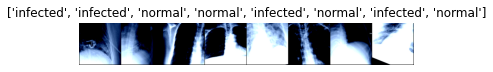

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## Task 1: Load pretrained CNN model and fine-tune FC Layers


# RESNET 18

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of RESNET18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freezing Layers except Last FC

In [0]:
# Removing last layer
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential()

In [0]:
for param in resnet18.parameters():
  param.require_grad = False

### Adding new Layers

In [0]:
fc = [nn.Linear(num_features,42*100+100),nn.Linear(42*100+100,len(class_names))]
fc

[Linear(in_features=512, out_features=4300, bias=True),
 Linear(in_features=4300, out_features=2, bias=True)]

In [0]:
resnet18.fc = fc[0]
resnet18.fc1 = fc[1]
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
nb_classes = 2

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        classes = class_names
        # print statistics
        running_loss += loss.item()
        
       # Append batch prediction results
        _, predicted = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])


        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'resnet18_FC_Only.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished Training


In [0]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

[[43489  5701]
 [ 3619 67191]]


In [0]:
training_confusion_matrix = conf_mat
training_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
training_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/training_confusion_matrix_DC_ONLY.csv', index=False)
print('Training Confusion Matrix',training_confusion_matrix)

Training Confusion Matrix [[43489  5701]
 [ 3619 67191]]


## Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


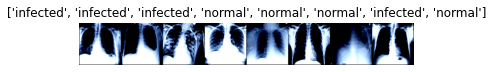

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected normal infected infected infected normal
Ground Truth:  infected normal infected normal infected infected infected normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 92 %


In [0]:
from sklearn.metrics import confusion_matrix
valid_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
validation_confusion_matrix = conf_mat
validation_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
validation_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/validation_confusion_matrix_FC_ONLY.csv', index=False)
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[43489  5701]
 [ 3619 67191]]


## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


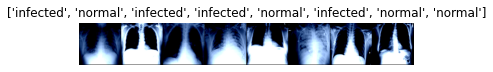

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected infected normal infected normal normal
Ground Truth:  infected normal infected infected normal infected normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 97 %


In [0]:
from sklearn.metrics import confusion_matrix
test_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
testing_confusion_matrix = test_conf_mat
testing_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
testing_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/testing_confusion_matrix_FC_ONLY.csv', index=False)
print('Testing Confusion Matrix',testing_confusion_matrix)

Testing Confusion Matrix [[595  20]
 [ 12 873]]


In [0]:
!cp resnet18_FC_Only.pth '/content/drive/My Drive/Deep Learning'

# Load VGG-16

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

## REMOVING LAST LAYER AND FREEZING ALL LAYERS

In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [0]:
for param in vgg16.parameters():
  param.requires_grad = False

In [0]:
features.extend([nn.Linear(num_features, 42*100+100)])
features.extend([nn.Linear(42*100+100, len(class_names))])
# features.extend([nn.Linear(num_features, len(class_names))])
features

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4300, bias=True),
 Linear(in_features=4300, out_features=2, bias=True)]

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        _, predicted = torch.max(outputs.data, 1)
        # print statistics
        running_loss += loss.item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished Training


In [0]:
from sklearn.metrics import confusion_matrix
train_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
training_confusion_matrix = train_conf_mat
training_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
training_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/training_confusion_matrix_vgg16_FC_ONLY.csv', index=False)
print('Training Confusion Matrix',training_confusion_matrix)

Training Confusion Matrix [[42455  6735]
 [ 3977 66833]]


## Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


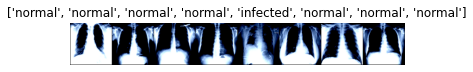

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal normal
Ground Truth:  normal normal normal normal infected normal normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 92 %


In [0]:
from sklearn.metrics import confusion_matrix
valid_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
valid_confusion_matrix = valid_conf_mat
valid_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
valid_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/valid_confusion_matrix_vgg16_FC_ONLY.csv', index=False)
print('Validation Confusion Matrix',training_confusion_matrix)

Validation Confusion Matrix [[42455  6735]
 [ 3977 66833]]


## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


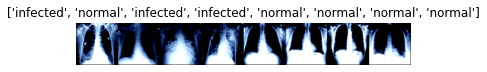

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal infected infected normal normal normal normal
Ground Truth:  infected normal infected infected normal normal normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 97 %


In [0]:
from sklearn.metrics import confusion_matrix
testing_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
testing_confusion_matrix = testing_conf_mat
testing_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
testing_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/testing_confusion_matrix_vgg16_FC_ONLY.csv', index=False)
print('Testing Confusion Matrix',training_confusion_matrix)

Testing Confusion Matrix [[42455  6735]
 [ 3977 66833]]


# Fine-tune the CNN and FC layers of the network

## RESNET-18

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of RESNET18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Layers Freezing

In [0]:
# Removing last layer
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential()

In [0]:
for param in resnet18.parameters():
  param.require_grad = False

### New Layer Addition

In [0]:
fc = [nn.Linear(num_features,42*100+100),nn.Linear(42*100+100,len(class_names))]
fc
resnet18.fc = fc[0]
resnet18.fc1 = fc[1]
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Unfreezing few Convolution Layers

In [0]:
resnet18.layer1[0].conv1.requires_grad=True
resnet18.layer1[0].conv2.requires_grad=True
resnet18.layer1[1].conv2.requires_grad=True

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
nb_classes = 2

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        classes = class_names
        # print statistics
        running_loss += loss.item()
        
       # Append batch prediction results
        _, predicted = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])


        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'resnet18_Few_CNN_Layers_Only.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished Training


In [0]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
training_confusion_matrix = conf_mat
training_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
training_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/training_confusion_matrix_resnet18_few_layers_onlye.csv', index=False)
print('Training Confusion Matrix',training_confusion_matrix)

Training Confusion Matrix [[42271  6919]
 [ 5154 65656]]


### Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


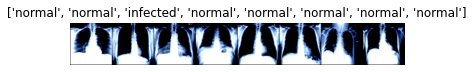

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected normal normal normal infected normal
Ground Truth:  normal normal infected normal normal normal normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 91 %


In [0]:
from sklearn.metrics import confusion_matrix
valid_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
validation_confusion_matrix = conf_mat
validation_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
validation_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/validation_confusion_matrix_resnet18_few_cnn_layers_ONLY.csv', index=False)
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[42271  6919]
 [ 5154 65656]]


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


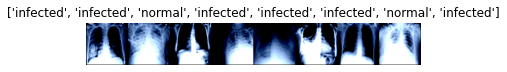

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal infected infected infected normal infected
Ground Truth:  infected infected normal infected infected infected normal infected


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the Testing images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the Testing images: 97 %


In [0]:
from sklearn.metrics import confusion_matrix
test_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
testing_confusion_matrix = test_conf_mat
testing_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
testing_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/testing_confusion_matrix_resnet18_few_cnn_layers_ONLY.csv', index=False)
print('Testing Confusion Matrix',testing_confusion_matrix)

Testing Confusion Matrix [[583  32]
 [  9 876]]


In [0]:
!cp resnet18_Few_CNN_Layers_Only.pth '/content/drive/My Drive/Deep Learning/'

### Unfreezing whole network

In [0]:
for param in resnet18.parameters():
  param.requires_grad = True

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
nb_classes = 2

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        classes = class_names
        # print statistics
        running_loss += loss.item()
        
       # Append batch prediction results
        _, predicted = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])


        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'resnet18_Full_Network.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished Training


In [0]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
training_confusion_matrix = conf_mat
training_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
training_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/training_confusion_matrix_resnet18_full_network.csv', index=False)
print('Training Confusion Matrix',training_confusion_matrix)

Training Confusion Matrix [[43571  5619]
 [ 3568 67242]]


### Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


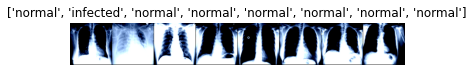

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal normal normal normal normal normal
Ground Truth:  normal infected normal normal normal normal normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 92 %


In [0]:
from sklearn.metrics import confusion_matrix
valid_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
validation_confusion_matrix = conf_mat
validation_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
validation_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/validation_confusion_matrix_resnet18_full_network.csv', index=False)
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[43571  5619]
 [ 3568 67242]]


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


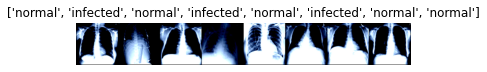

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal infected normal infected normal normal
Ground Truth:  normal infected normal infected normal infected normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the Testing images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the Testing images: 97 %


In [0]:
from sklearn.metrics import confusion_matrix
test_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
testing_confusion_matrix = test_conf_mat
testing_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
testing_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/testing_confusion_matrix_resnet18_full_network.csv', index=False)
print('Testing Confusion Matrix',testing_confusion_matrix)

Testing Confusion Matrix [[588  27]
 [  8 877]]


In [0]:
!cp resnet18_Full_Network.pth '/content/drive/My Drive/Deep Learning/'

## VGG-16

In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### REMOVING LAST LAYER AND FREEZING ALL LAYERS

In [14]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [15]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [0]:
for param in vgg16.parameters():
  param.requires_grad = False

In [17]:
features.extend([nn.Linear(num_features, 42*100+100)])
features.extend([nn.Linear(42*100+100, len(class_names))])
# features.extend([nn.Linear(num_features, len(class_names))])
features

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4300, bias=True),
 Linear(in_features=4300, out_features=2, bias=True)]

In [18]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Unfreezing few Convolution Layers

In [0]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
vgg16.features[0].requires_grad = True
vgg16.features[2].requires_grad = True
vgg16.features[5].requires_grad = True
vgg16.features[7].requires_grad = True

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
nb_classes = 2

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        classes = class_names
        # print statistics
        running_loss += loss.item()
        
       # Append batch prediction results
        _, predicted = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])


        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_Few_CNN_Layers_Only.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished Training


In [0]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
training_confusion_matrix = conf_mat
training_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
training_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/training_confusion_matrix_vgg16_few_layers_onlye.csv', index=False)
print('Training Confusion Matrix',training_confusion_matrix)

Training Confusion Matrix [[35475 13715]
 [11793 59017]]


### Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


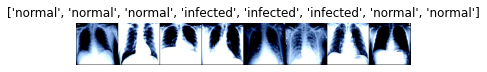

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal infected infected infected normal normal
Ground Truth:  normal normal normal infected infected infected normal normal


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 81 %


In [0]:
from sklearn.metrics import confusion_matrix
valid_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
validation_confusion_matrix = conf_mat
validation_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
validation_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/validation_confusion_matrix_vgg16_few_cnn_layers_ONLY.csv', index=False)
print('Validation Confusion Matrix',validation_confusion_matrix)

Validation Confusion Matrix [[35475 13715]
 [11793 59017]]


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


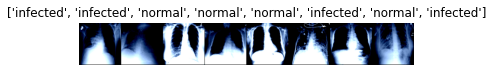

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal normal normal infected normal infected
Ground Truth:  infected infected normal normal normal infected normal infected


In [0]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the Testing images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the Testing images: 87 %


In [0]:
from sklearn.metrics import confusion_matrix
test_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
testing_confusion_matrix = test_conf_mat
testing_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
testing_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/testing_confusion_matrix_vgg16_few_cnn_layers_ONLY.csv', index=False)
print('Testing Confusion Matrix',testing_confusion_matrix)

Testing Confusion Matrix [[510 105]
 [ 82 803]]


In [0]:
!cp vgg16_Few_CNN_Layers_Only.pth '/content/drive/My Drive/Deep Learning/'

### Unfreezing whole network

In [0]:
for param in vgg16.parameters():
  param.requires_grad = True

### Training

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [22]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
nb_classes = 2

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm_notebook(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        classes = class_names
        # print statistics
        running_loss += loss.item()
        
       # Append batch prediction results
        _, predicted = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])


        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_Full_Network.pth')

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Finished Training


In [23]:
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
training_confusion_matrix = conf_mat
training_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
training_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/training_confusion_matrix_vgg16_full_network.csv', index=False)
print('Training Confusion Matrix',training_confusion_matrix)

Training Confusion Matrix [[42001  7189]
 [ 3968 66842]]


### Validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


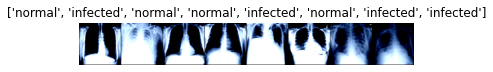

In [24]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [26]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal infected normal normal infected normal infected infected
Ground Truth:  normal infected normal normal infected normal infected infected


In [27]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
valid_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [0]:
validation_confusion_matrix = conf_mat
validation_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
validation_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/validation_confusion_matrix_vgg16_full_network.csv', index=False)
print('Validation Confusion Matrix',validation_confusion_matrix)

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


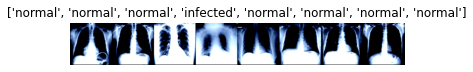

In [28]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [29]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal normal normal
Ground Truth:  normal normal normal infected normal normal normal normal


In [30]:
correct = 0
total = 0
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
print('Accuracy of the network on the Testing images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the Testing images: 96 %


In [0]:
from sklearn.metrics import confusion_matrix
test_conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())

In [32]:
testing_confusion_matrix = test_conf_mat
testing_confusion_matrix_pd = pd.DataFrame(data=training_confusion_matrix,columns=[class_names[0], class_names[1]])
testing_confusion_matrix_pd.to_csv('/content/drive/My Drive/Deep Learning/testing_confusion_matrix_vgg16_full_network.csv', index=False)
print('Testing Confusion Matrix',testing_confusion_matrix)

Testing Confusion Matrix [[570  45]
 [  8 877]]


In [0]:
!cp vgg16_Full_Network.pth '/content/drive/My Drive/Deep Learning/'